# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [3]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date', 
    parse_dates=True, 
    infer_datetime_format=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

/var/folders/66/l9mtp03x717f2byqj27ynxqh0000gn/T/ipykernel_24950/1096498906.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_mercado_trends = pd.read_csv(
/var/folders/66/l9mtp03x717f2byqj27ynxqh0000gn/T/ipykernel_24950/1096498906.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [4]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


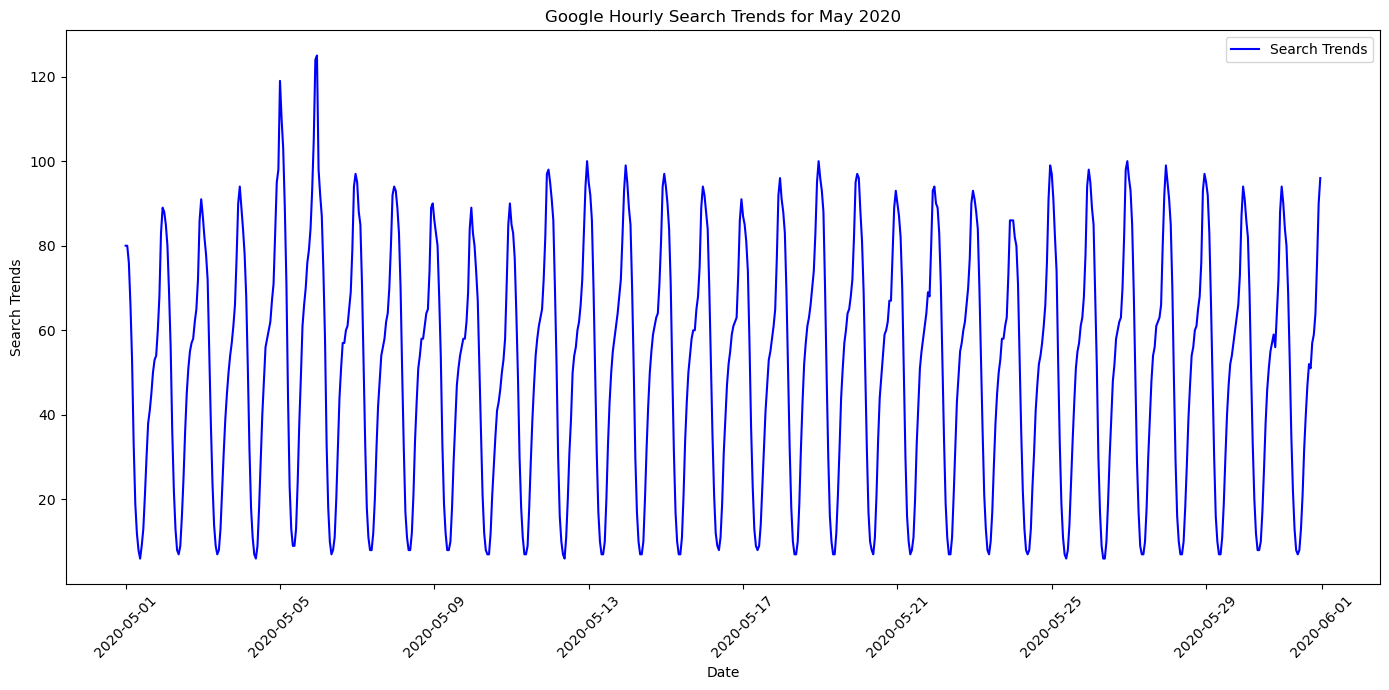

In [5]:
# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc['2020-05']
# Plot to visualize the data for May 2020
plt.figure(figsize=(14, 7))
plt.plot(df_may_2020.index, df_may_2020['Search Trends'], label='Search Trends', color='blue')
plt.title('Google Hourly Search Trends for May 2020')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [6]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_may_2020['Search Trends'].sum()

# View the traffic_may_2020 value
print(traffic_may_2020)

38181


In [7]:
# Calcluate the monhtly median search traffic across all months 
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month])['Search Trends'].sum().median()

# View the median_monthly_traffic value
print(median_monthly_traffic)


35172.5


In [8]:
# To compare the seach traffic for the month of May 2020 to the overall monthly median value,
# Divide the may traffic total by the median monthly traffic
comparison_value = traffic_may_2020 / median_monthly_traffic

# View the comparison_value
print(comparison_value)



1.0855355746677091


##### Answer the following question: 

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes, the Google search traffic increased during the month that MercadoLibre released its financial results. The comparison value of approximately 1.086 suggests that the total search traffic for May 2020 was about 8.55% higher than the median monthly traffic across all months. This increase in search traffic could be attributed to heightened public interest and investor activity following the release of the company's financial outcomes.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

Date
0     88.324289
1     84.408150
2     76.419793
3     61.954075
4     43.720569
5     26.406856
6     14.459897
7      8.371928
8      6.150712
9      7.384864
10    12.699871
11    22.523286
12    33.452781
13    41.648771
14    47.807891
15    51.516818
16    53.333765
17    55.810479
18    57.659767
19    59.500000
20    62.643596
21    69.803364
22    80.777490
23    88.258732
Name: Search Trends, dtype: float64


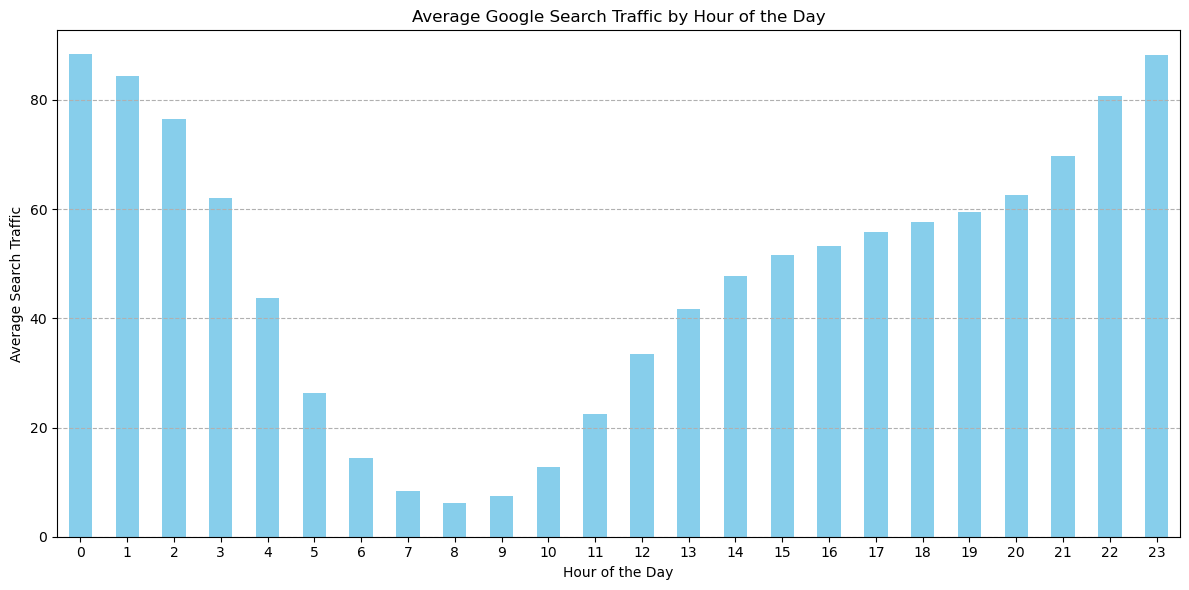

In [9]:
# Group the hourly search data to plot the average traffic by the day of week 
average_traffic_by_hour = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()
print(average_traffic_by_hour)

plt.figure(figsize=(12, 6))
average_traffic_by_hour.plot(kind='bar', color='skyblue')
plt.title('Average Google Search Traffic by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Search Traffic')
plt.xticks(rotation=0)  # To keep the x-axis labels readable
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

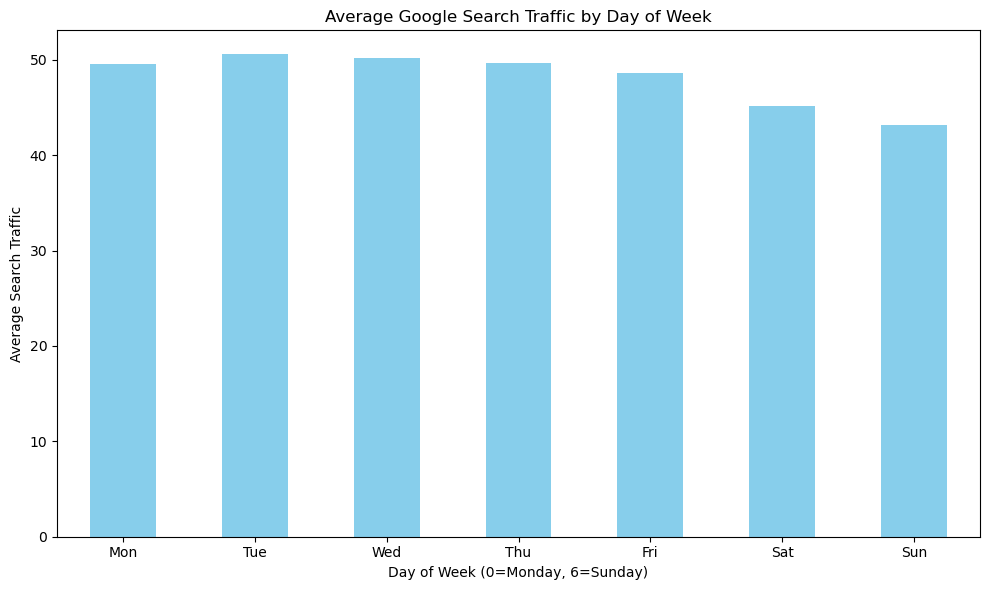

In [10]:
# Group the hourly search data to plot the average traffic by the day of week 
# Add a column for the numerical day of the week (Monday=0, Sunday=6)
df_mercado_trends['Day of Week (Numeric)'] = df_mercado_trends.index.dayofweek

# Group by the numerical day of the week and calculate the mean search trends
average_traffic_by_numeric_day_of_week = df_mercado_trends.groupby('Day of Week (Numeric)')['Search Trends'].mean()

# Plot the average traffic by the numerical day of the week
plt.figure(figsize=(10, 6))
average_traffic_by_numeric_day_of_week.plot(kind='bar', color='skyblue')
plt.title('Average Google Search Traffic by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Search Traffic')
plt.xticks(ticks=range(0, 7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.tight_layout()
plt.show()


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

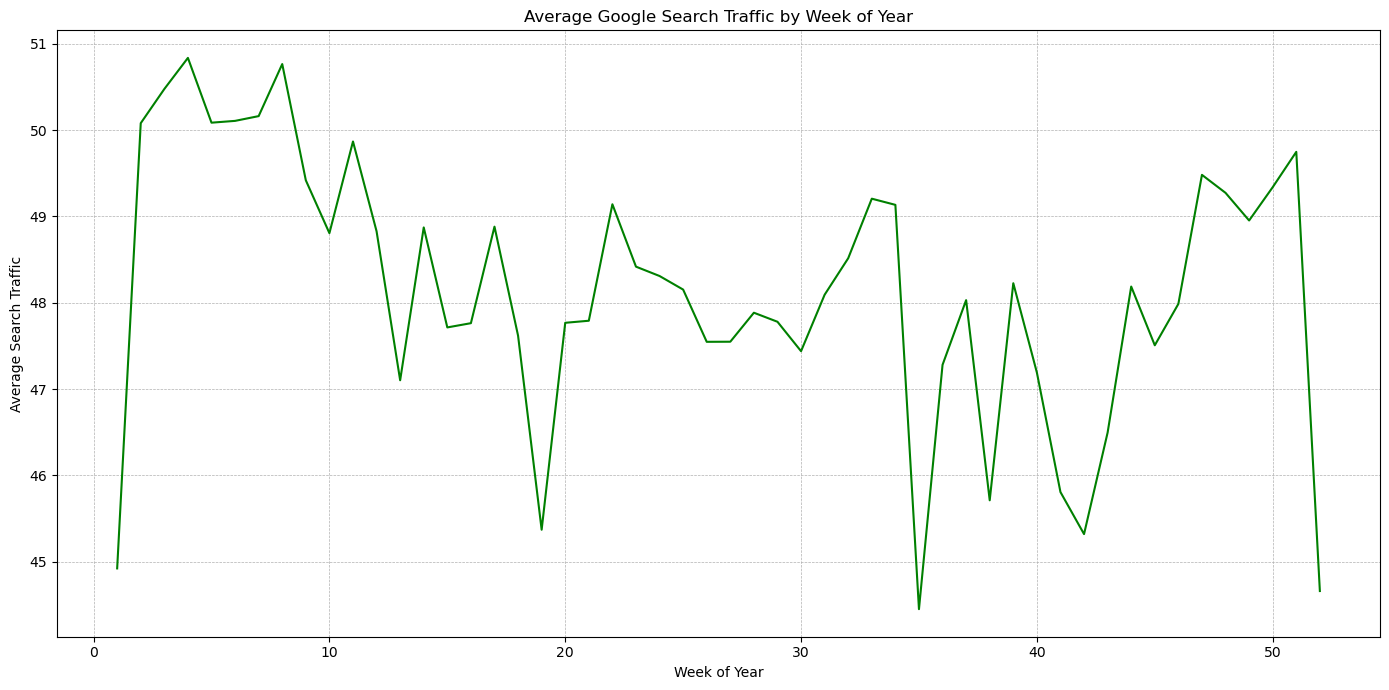

In [11]:
# Group the hourly search data to plot the average traffic by the week of the year 
# Add a column for the week of the year
df_mercado_trends['Week of Year'] = df_mercado_trends.index.isocalendar().week

# Group by the week of the year and calculate the mean search trends
average_traffic_by_week_of_year = df_mercado_trends.groupby('Week of Year')['Search Trends'].mean()

# Plot the average traffic by the week of the year
plt.figure(figsize=(14, 7))
average_traffic_by_week_of_year.plot(kind='line', color='green')
plt.title('Average Google Search Traffic by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Average Search Traffic')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** The hourly traffic data suggests early AM (e.g. 7-9am) is a bad time to market, perhaps #people are commuting, starting work, etc. Similarly weekends show a drop in traffic along with #weeks roughly 0, 20, 35, 52, which likely corresponds to holiday/vacation time.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [12]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True, 
    infer_datetime_format=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

/var/folders/66/l9mtp03x717f2byqj27ynxqh0000gn/T/ipykernel_24950/880024568.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_mercado_stock = pd.read_csv(


,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


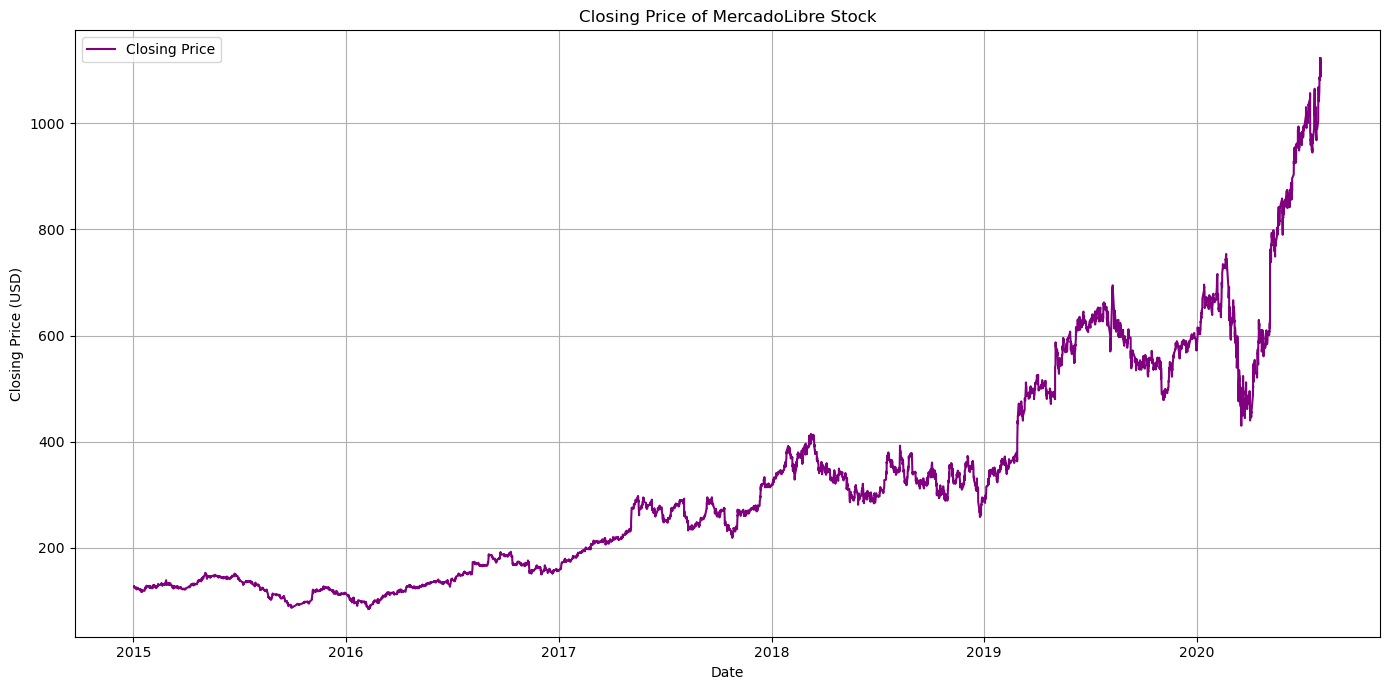

In [13]:
# Visualize the closing price of the df_mercado_stock DataFrame
plt.figure(figsize=(14, 7))
plt.plot(df_mercado_stock.index, df_mercado_stock['close'], label='Closing Price', color='purple')
plt.title('Closing Price of MercadoLibre Stock')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
# Ensure both DataFrames have the same date format in the index for accurate concatenation
df_mercado_stock_reset = df_mercado_stock.reset_index()
df_mercado_trends_reset = df_mercado_trends.reset_index()

# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
df_combined_reset = pd.concat([df_mercado_stock_reset, df_mercado_trends_reset], axis=1).dropna()
df_combined_reset.set_index('date', inplace=True)


# View the first and last five rows of the DataFrame
print(df_combined_reset.head())
print(df_combined_reset.tail())


                      close                Date  Search Trends  \
date                                                             
2015-01-02 09:00:00  127.67 2016-06-01 00:00:00             97   
2015-01-02 10:00:00  125.44 2016-06-01 01:00:00             92   
2015-01-02 11:00:00  125.57 2016-06-01 02:00:00             76   
2015-01-02 12:00:00  125.40 2016-06-01 03:00:00             60   
2015-01-02 13:00:00  125.17 2016-06-01 04:00:00             38   

                     Day of Week (Numeric)  Week of Year  
date                                                      
2015-01-02 09:00:00                      2            22  
2015-01-02 10:00:00                      2            22  
2015-01-02 11:00:00                      2            22  
2015-01-02 12:00:00                      2            22  
2015-01-02 13:00:00                      2            22  
                        close                Date  Search Trends  \
date                                                    

#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [16]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06) 
first_half_2020 = df_combined_reset.loc['2020-01':'2020-06']

# View the first and last five rows of first_half_2020 DataFrame
print(first_half_2020.head())
print(first_half_2020.tail())


                       close                Date  Search Trends  \
date                                                              
2020-01-02 09:00:00  601.085 2017-05-12 21:00:00             59   
2020-01-02 10:00:00  601.290 2017-05-12 22:00:00             68   
2020-01-02 11:00:00  615.410 2017-05-12 23:00:00             75   
2020-01-02 12:00:00  611.400 2017-05-13 00:00:00             76   
2020-01-02 13:00:00  611.830 2017-05-13 01:00:00             72   

                     Day of Week (Numeric)  Week of Year  
date                                                      
2020-01-02 09:00:00                      4            19  
2020-01-02 10:00:00                      4            19  
2020-01-02 11:00:00                      4            19  
2020-01-02 12:00:00                      5            19  
2020-01-02 13:00:00                      5            19  
                      close                Date  Search Trends  \
date                                               

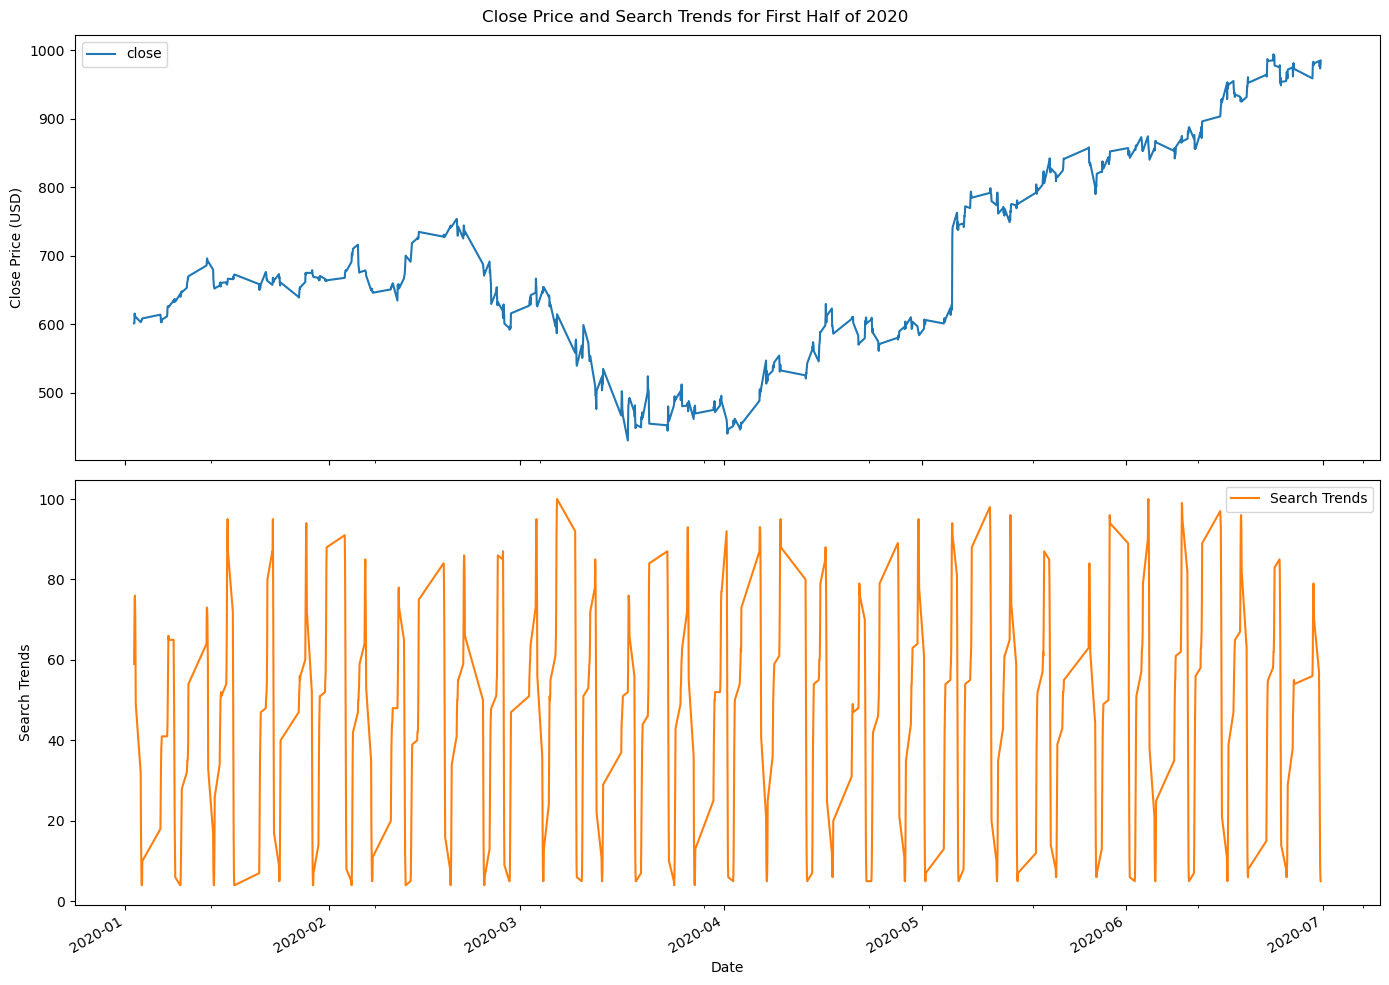

In [17]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`

ax = first_half_2020[['close', 'Search Trends']].plot(subplots=True, figsize=(14, 10), title='Close Price and Search Trends for First Half of 2020')

# Set the labels for x-axis and y-axis
ax[0].set_ylabel('Close Price (USD)')
ax[1].set_ylabel('Search Trends')

# Set the label for the x-axis
for a in ax:
    a.set_xlabel('Date')

plt.tight_layout()
plt.show()


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** In truth, our evidence of a common trend between search activity and stock price is pretty limited. It does appear generally however that the low point for Mercado Libre's stock price, late March to early April, did coincide with lower search activity for the firm. Search activity does pick up along with its stock price, although the stock price from mid-April onward definitively outpaces search interest.

There's one important thing to note: if you zoom in both graphs to the spike around May 5th, 2020, you'll find the date of the company's earnings release to the public. It looks like search traffic for the firm spiked about two hours before the firm's stock price spiked. This could indicate a predictable pattern (can Google Searches predict the stock price?), but an alternative explanation might just be that people tend to search for more information about the firm right before an earnings announcement gets released. We'd need to do a little more time-series research to see which explanation best fits the data.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [18]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
df_combined_reset['Lagged Search Trends'] = df_combined_reset['Search Trends'].shift(1)
# View the first five rows to verify the new column
print(df_combined_reset[['Search Trends', 'Lagged Search Trends']].head())



                     Search Trends  Lagged Search Trends
date                                                    
2015-01-02 09:00:00             97                   NaN
2015-01-02 10:00:00             92                  97.0
2015-01-02 11:00:00             76                  92.0
2015-01-02 12:00:00             60                  76.0
2015-01-02 13:00:00             38                  60.0


In [19]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window

df_combined_reset['Stock Returns'] = df_combined_reset['close'].pct_change()

# Calculate the rolling standard deviation of stock returns over a 4-period window for stock volatility
df_combined_reset['Stock Volatility'] = df_combined_reset['Stock Returns'].rolling(window=4).std()


                      close  Stock Returns  Stock Volatility
date                                                        
2015-01-02 09:00:00  127.67            NaN               NaN
2015-01-02 10:00:00  125.44      -0.017467               NaN
2015-01-02 11:00:00  125.57       0.001036               NaN
2015-01-02 12:00:00  125.40      -0.001354               NaN
2015-01-02 13:00:00  125.17      -0.001834          0.008468
2015-01-02 14:00:00  125.77       0.004793          0.003028
2015-01-02 15:00:00  125.74      -0.000239          0.003042
2015-01-05 09:00:00  124.65      -0.008669          0.005559
2015-01-05 10:00:00  124.64      -0.000080          0.005591
2015-01-05 11:00:00  124.20      -0.003530          0.004021


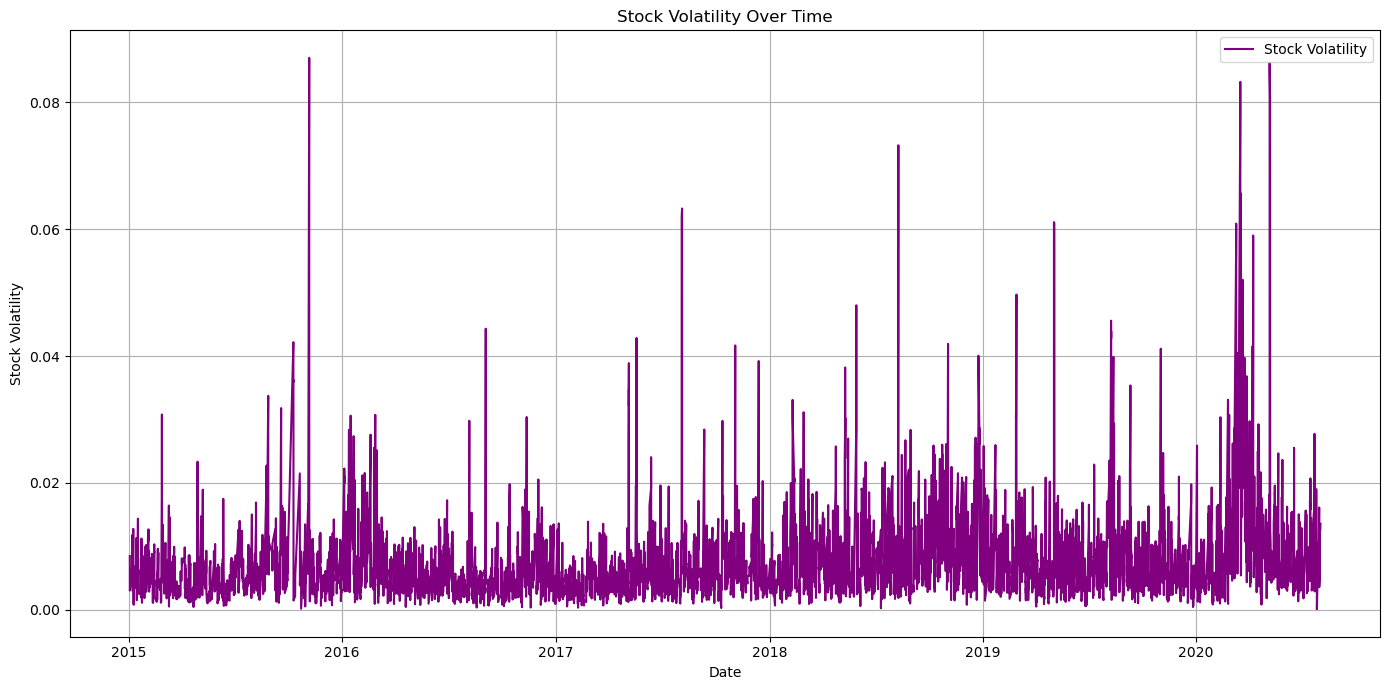

In [20]:
# Visualize the stock volatility
# View the first ten rows to verify the new columns
print(df_combined_reset[['close', 'Stock Returns', 'Stock Volatility']].head(10))

# Visualize the stock volatility

plt.figure(figsize=(14, 7))
plt.plot(df_combined_reset.index, df_combined_reset['Stock Volatility'], label='Stock Volatility', color='purple')
plt.title('Stock Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [21]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
df_combined_reset['Hourly Stock Return'] = df_combined_reset['close'].pct_change() * 100
print(df_combined_reset[['close', 'Hourly Stock Return']].head(10))
# Display the first five rows of the DataFrame
print("First five rows:")
print(df_combined_reset.head())
# Display a separator for clarity
print("\n" + "-"*50 + "\n")



                      close  Hourly Stock Return
date                                            
2015-01-02 09:00:00  127.67                  NaN
2015-01-02 10:00:00  125.44            -1.746691
2015-01-02 11:00:00  125.57             0.103635
2015-01-02 12:00:00  125.40            -0.135383
2015-01-02 13:00:00  125.17            -0.183413
2015-01-02 14:00:00  125.77             0.479348
2015-01-02 15:00:00  125.74            -0.023853
2015-01-05 09:00:00  124.65            -0.866868
2015-01-05 10:00:00  124.64            -0.008022
2015-01-05 11:00:00  124.20            -0.353017
First five rows:
                      close                Date  Search Trends  \
date                                                             
2015-01-02 09:00:00  127.67 2016-06-01 00:00:00             97   
2015-01-02 10:00:00  125.44 2016-06-01 01:00:00             92   
2015-01-02 11:00:00  125.57 2016-06-01 02:00:00             76   
2015-01-02 12:00:00  125.40 2016-06-01 03:00:00             60   

In [23]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
# Display the last five rows of the DataFrame
print("Last five rows:")
print(df_combined_reset.tail())
print("First five rows:")
print(df_combined_reset.head())

Last five rows:
                        close                Date  Search Trends  \
date                                                               
2020-07-31 11:00:00  1105.780 2017-06-24 19:00:00             55   
2020-07-31 12:00:00  1087.925 2017-06-24 20:00:00             58   
2020-07-31 13:00:00  1095.800 2017-06-24 21:00:00             65   
2020-07-31 14:00:00  1110.650 2017-06-24 22:00:00             76   
2020-07-31 15:00:00  1122.510 2017-06-24 23:00:00             83   

                     Day of Week (Numeric)  Week of Year  \
date                                                       
2020-07-31 11:00:00                      5            25   
2020-07-31 12:00:00                      5            25   
2020-07-31 13:00:00                      5            25   
2020-07-31 14:00:00                      5            25   
2020-07-31 15:00:00                      5            25   

                     Lagged Search Trends  Stock Returns  Stock Volatility  \
date    

#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [24]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
correlation_table = df_combined_reset[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()
print(correlation_table)


                      Stock Volatility  Lagged Search Trends  \
Stock Volatility              1.000000              0.009864   
Lagged Search Trends          0.009864              1.000000   
Hourly Stock Return           0.065125             -0.012362   

                      Hourly Stock Return  
Stock Volatility                 0.065125  
Lagged Search Trends            -0.012362  
Hourly Stock Return              1.000000  


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** If we read down the second column (or read along the second row), we see that there's a slight negative correlation between searches for the firm and its subsequent stock volatility. More searches (slightly) tend to indicate less near-term hourly stock risk for the firm.

On the other hand, there's a positive correlation between search activity in one hour and stock returns in the next: as search activity goes up, so will the firm's stock price in the short term. This effect is very weak though, only half the size of the effect on stock volatility. With the correlation so close to zero, some might also say that there's almost no relationship between these two variables whatsoever, and that the small findings that we do have could be just due to chance. While there's no required threshold when looking at correlation between stock returns and the variables used to predict them, it does tend to be that correlations in this context tend to be very low across the board. It's hard to predict the market!

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [25]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
prophet_df = df_combined_reset.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
prophet_df = prophet_df.rename(columns={'date': 'ds', 'Search Trends': 'y'})

# Drop an NaN values from the prophet_df DataFrame
prophet_df.dropna(subset=['y'], inplace=True)

# View the first and last five rows of the mercado_prophet_df DataFrame
print("First five rows:")
print(prophet_df[['ds', 'y']].head())

print("\n" + "-"*50 + "\n")

print("Last five rows:")
print(prophet_df[['ds', 'y']].tail())


First five rows:
                   ds   y
0 2015-01-02 09:00:00  97
1 2015-01-02 10:00:00  92
2 2015-01-02 11:00:00  76
3 2015-01-02 12:00:00  60
4 2015-01-02 13:00:00  38

--------------------------------------------------

Last five rows:
                      ds   y
9331 2020-07-31 11:00:00  55
9332 2020-07-31 12:00:00  58
9333 2020-07-31 13:00:00  65
9334 2020-07-31 14:00:00  76
9335 2020-07-31 15:00:00  83


In [26]:
# Call the Prophet function, store as an object
model = Prophet()

In [27]:
# Fit the time-series model.
model.fit(prophet_df)


16:59:15 - cmdstanpy - INFO - Chain [1] start processing
16:59:17 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future = model.make_future_dataframe(periods=2000, freq='H')
future.tail()  


# View the last five rows of the future_mercado_trends DataFrame


,ds
11331,2020-10-22 19:00:00
11332,2020-10-22 20:00:00
11333,2020-10-22 21:00:00
11334,2020-10-22 22:00:00
11335,2020-10-22 23:00:00


In [29]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast = model.predict(future)

# Display the first five rows of the forecast_mercado_trends DataFrame
print(forecast.head())


                   ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2015-01-02 09:00:00  39.348000   13.049080   79.453015    39.348000   
1 2015-01-02 10:00:00  39.347975   12.324116   80.588971    39.347975   
2 2015-01-02 11:00:00  39.347950   12.358721   78.436433    39.347950   
3 2015-01-02 12:00:00  39.347925   13.093551   76.725742    39.347925   
4 2015-01-02 13:00:00  39.347900    9.630419   78.639234    39.347900   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    39.348000        7.412870              7.412870              7.412870   
1    39.347975        7.162869              7.162869              7.162869   
2    39.347950        6.580883              6.580883              6.580883   
3    39.347925        6.399129              6.399129              6.399129   
4    39.347900        5.808099              5.808099              5.808099   

      daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0  3.515374  ...  2.5164

#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

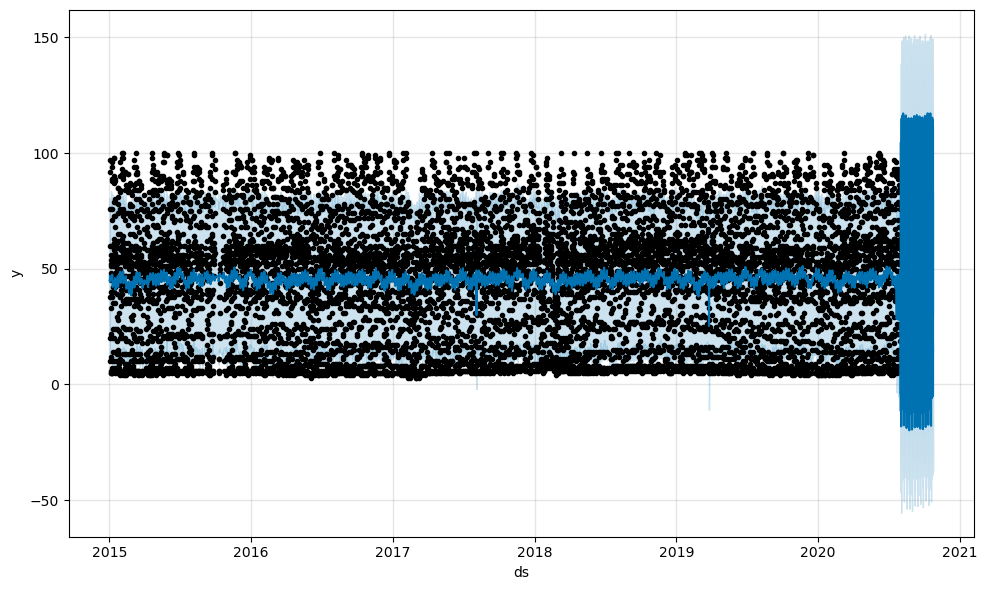

In [30]:
# Plot the Prophet predictions for the Mercado trends data
fig = model.plot(forecast)


##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** 
The short-term forecast predicts an upward trend in the popularity of MercadoLibre in the near term. It is important to note the confidence interval, is also widening, suggesting increasing uncertainty with the predictions further into the future. 

#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [31]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast.set_index('ds', inplace=True)

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast[['yhat', 'yhat_lower', 'yhat_upper']].head()



,yhat,yhat_lower,yhat_upper
ds,,,
2015-01-02 09:00:00,46.760870,13.049080,79.453015
2015-01-02 10:00:00,46.510844,12.324116,80.588971
2015-01-02 11:00:00,45.928834,12.358721,78.436433
2015-01-02 12:00:00,45.747055,13.093551,76.725742
2015-01-02 13:00:00,45.155999,9.630419,78.639234


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

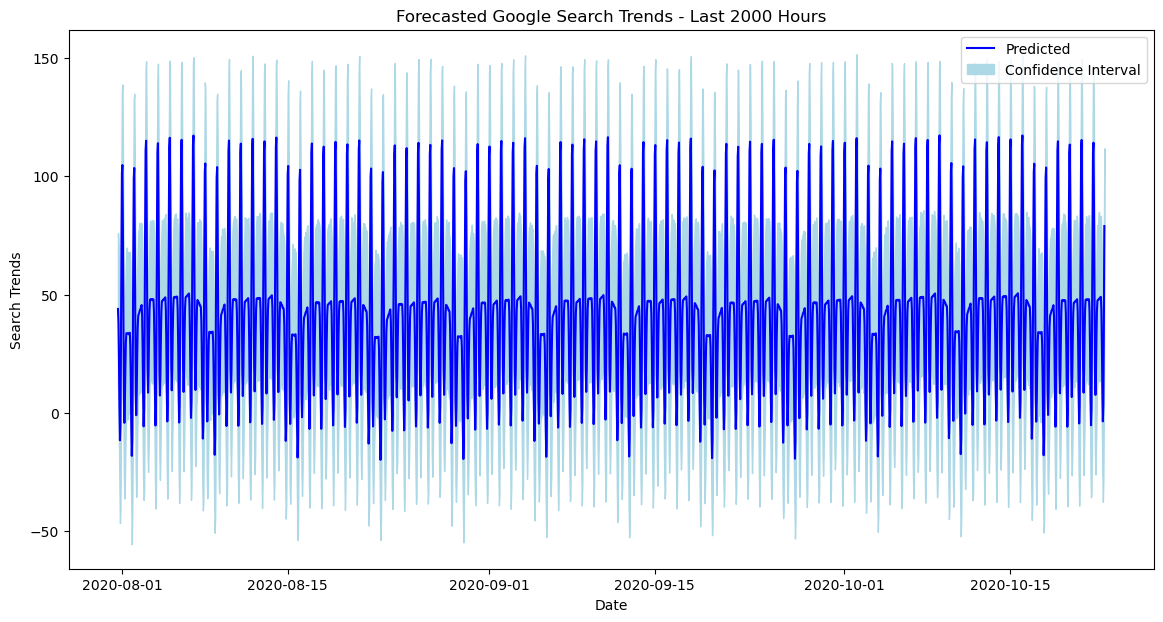

In [32]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours

plt.figure(figsize=(14, 7))
plt.plot(forecast['yhat'].last('2000H'), label='Predicted', color='blue')
plt.fill_between(forecast.last('2000H').index, 
                 forecast['yhat_lower'].last('2000H'), 
                 forecast['yhat_upper'].last('2000H'), 
                 color='lightblue', 
                 label='Confidence Interval')
plt.title('Forecasted Google Search Trends - Last 2000 Hours')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.legend()
plt.show()


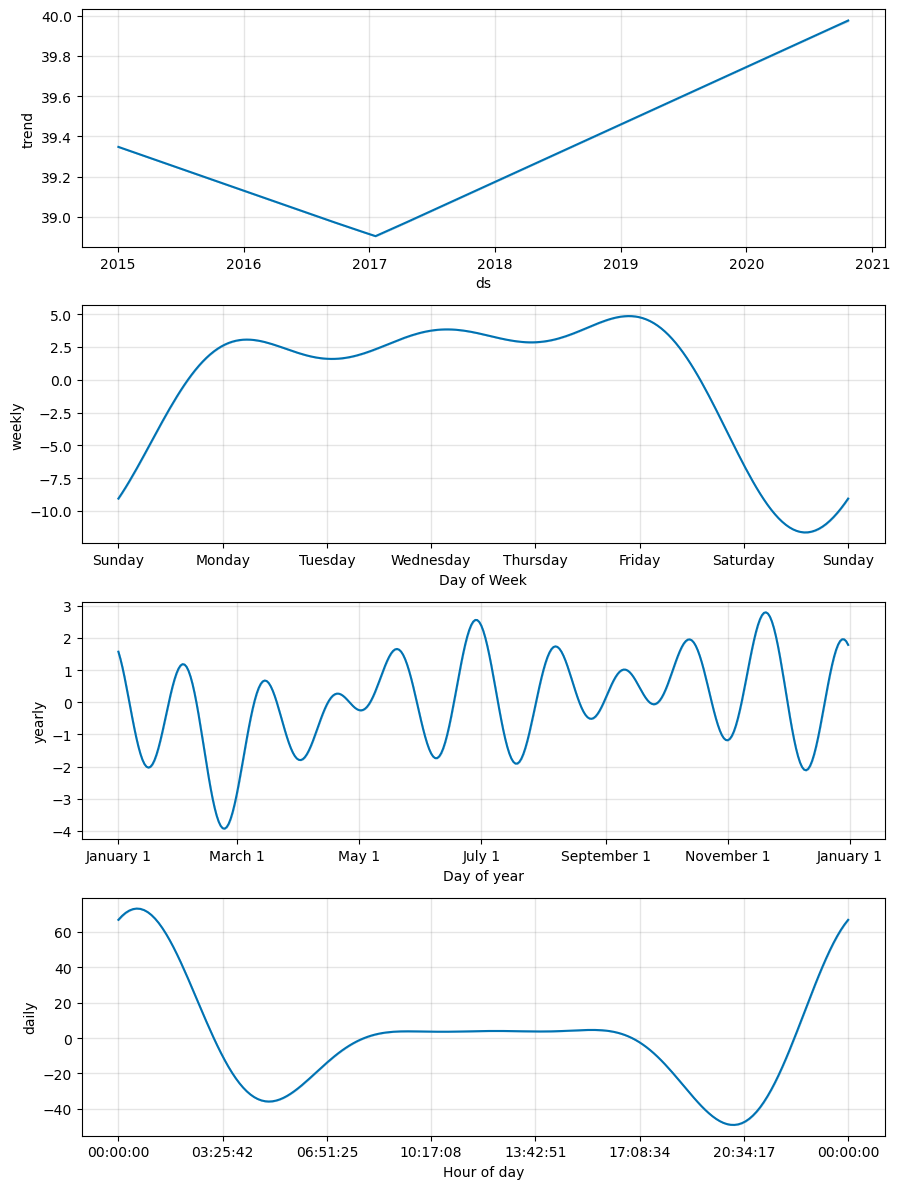

In [33]:
# Reset the index in the forecast_mercado_trends DataFrame

forecast.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results 
# for the forecast_canada DataFrame 
fig_components = model.plot_components(forecast)


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** The evening hours approaching Midnight appears to be the most popular times.

**Question:** Which day of week gets the most search traffic? 
   
**Answer:** Friday.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** End of February / early March.
